In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm
import joblib


# 母平均の信頼区間
- 指数分布を考える
- 上側信頼区間を計算する

In [11]:
mean_true = 2.0
alpha = 0.05
# sample: rng.exponential(scale = mean_true, size = n)


In [12]:
def calc_conf_interval_normal(x: np.ndarray, alpha: float = 0.05) -> float:
    """
    Calculates the confidence interval for a given sample x.
    """
    n = len(x)
    x_mean = np.mean(x)
    x_std = np.std(x, ddof=1)
    z_alpha = stats.norm.ppf(1-alpha)
    ci = z_alpha * x_std / np.sqrt(n)
    return x_mean + ci


In [15]:
def calc_conf_interval_bs(rng: np.random.Generator, x: np.ndarray, alpha: float = 0.05, mc: int = 1000) -> float:
    n = len(x)
    x_mean = np.mean(x)
    bs_samples = rng.exponential(x_mean, size=(mc, n))
    bs_means = np.mean(bs_samples, axis=1)
    bs_stds = np.std(bs_samples, axis=1, ddof=1)
    studentized_samples = np.sqrt(n) * (bs_means - x_mean) / bs_stds
    upper = np.quantile(studentized_samples, 1-alpha)
    return x_mean + upper * np.std(x, ddof=1) / np.sqrt(n)  # これ合ってる?


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 9200 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 9200 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 9200 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8688 tasks      | ela

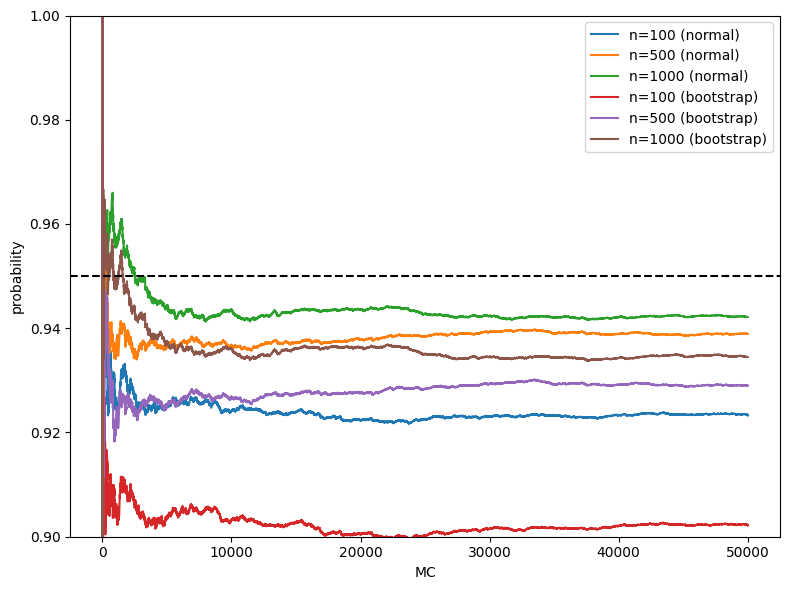

In [19]:
# 信頼区間を計算して、真の平均が信頼区間に入っている確率が 1-alpha=0.95 になるか確認する
# normal version
DEBUG = False

SEED = 42
n_list = [100, 500, 1000]

if DEBUG:
    MC = 1000
else:
    MC = 50000

prob_seq_list_normal = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]
    def main(rng):
        x = rng.exponential(scale = mean_true, size = n)
        upper = calc_conf_interval_normal(x, alpha)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(joblib.delayed(main)(rng) for rng in streams)
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC+1))
    prob_seq_list_normal.append(prob_seq)

# bootstrap version
mc_bs = 1000  # bootstrapのサンプル数
prob_seq_list_bs = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]
    def main(rng):
        x = rng.exponential(scale = mean_true, size = n)
        upper = calc_conf_interval_bs(rng, x, alpha, mc = mc_bs)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(joblib.delayed(main)(rng) for rng in streams)
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC+1))
    prob_seq_list_bs.append(prob_seq)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for n, prob_seq in zip(n_list, prob_seq_list_normal):
    sns.lineplot(prob_seq, label=f"n={n} (normal)", ax=ax)
for n, prob_seq in zip(n_list, prob_seq_list_bs):
    sns.lineplot(prob_seq, label=f"n={n} (bootstrap)", ax=ax)
ax.legend()
ax.set_xlabel("MC")
ax.set_ylabel("probability")
ax.set_ylim(1-alpha-0.05, 1-alpha+0.05)
ax.axhline(1-alpha, color = 'k', linestyle = '--')
fig.tight_layout()
